# Data Exploration

In [1]:
#Imports
import os
import re
import nltk
import warnings
import unicodedata
import nltk.sentiment

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.util import ngrams
from env import get_connection
from wordcloud import WordCloud
from acquire import get_blog_articles_data, get_news_article, get_new_links

warnings.filterwarnings('ignore')

## Spam

#### 1) Spam Data
Load the spam data set.
Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
Is there any overlap in the bigrams for the spam data and the ham data?
Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

#### Acquire spam data

In [2]:
# Get SQL database URL
url = get_connection('spam_db')

# Define SQL query to select all columns from a table named 'spam'
query = '''
        SELECT *
        FROM spam
        '''

In [3]:
# Read data from the SQL database using the provided SQL query and connection URL
df = pd.read_sql(query, url, index_col='id')

df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Count the occurrences of each unique value in the 'label' column of the DataFrame
label_counts = df['label'].value_counts()

In [5]:
# Join a list of strings into a single string with space as the separator
resulting_string = ' '.join(['this', 'is', 'a', 'list', 'of', 'strings'])

In [6]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', '4', 'ltgt']

def clean(text):
    '''
    A simple function to cleanup text data.
    
    Args:
        text (str): The text to be cleaned.
        
    Returns:
        list: A list of lemmatized words after cleaning.
    '''
    
    # Normalize text by removing diacritics, encoding to ASCII, decoding to UTF-8, and converting to lowercase
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    
    # Remove punctuation and split text into words
    words = re.sub(r'[^\w\s]', '', text).split()
    
    # Initialize WordNet lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Combine standard English stopwords with additional stopwords
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    
    # Lemmatize words and remove stopwords
    cleaned_words = [wnl.lemmatize(word) for word in words if word not in stopwords]
    
    return cleaned_words

In [7]:
# Preprocess text data for 'ham' label
ham_words = clean(' '.join(df[df.label == "ham"]['text']))

# Preprocess text data for 'spam' label
spam_words = clean(' '.join(df[df.label == "spam"]['text']))

# Preprocess all text data
all_words = clean(' '.join(df['text']))

In [8]:
# Calculate the number of words in the 'all_words' set
all_words_count = len(all_words)

# Calculate the number of words in the 'spam_words' set
spam_words_count = len(spam_words)

# Calculate the number of words in the 'ham_words' set
ham_words_count = len(ham_words)

all_words_count, spam_words_count, ham_words_count

(50018, 12044, 37974)

### Exploration

In [9]:
# Calculate word frequencies for the 'ham_words' set
ham_freq = pd.Series(ham_words).value_counts()

# Calculate word frequencies for the 'spam_words' set
spam_freq = pd.Series(spam_words).value_counts()

# Calculate word frequencies for the 'all_words' set
all_freq = pd.Series(all_words).value_counts()

In [10]:
spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
Name: count, dtype: int64

In [11]:
ham_freq.head()

im      449
get     314
go      273
ok      272
dont    257
Name: count, dtype: int64

In [12]:
# Combine word counts for 'ham', 'spam', and 'all' sets into a DataFrame
word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)

# Set column names to 'ham', 'spam', and 'all'
word_counts.columns = ['ham', 'spam', 'all']

# Display the first few rows of the DataFrame
word_counts.head()

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279


In [13]:
# Sort the 'word_counts' DataFrame by the 'all' column in descending order
# and display the top few rows
word_counts_sorted = word_counts.sort_values('all', ascending=False).head()
word_counts_sorted

,ham,spam,all
call,241,359,600
im,449,13,462
get,314,83,397
ur,240,144,384
go,273,31,304


In [14]:
# Sort the 'word_counts' DataFrame by the columns 'ham,' 'spam,' and 'all' in descending order
# and display the top few rows
word_counts_sorted = word_counts.sort_values(['ham', 'spam', 'all'], ascending=False).head()
word_counts_sorted

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279


### Visualization

In [15]:
# Set the figure size for Matplotlib plots
plt.rc('figure', figsize=(13, 7))

# Set the style for Matplotlib plots to 'seaborn-darkgrid'
plt.style.use('seaborn-darkgrid')

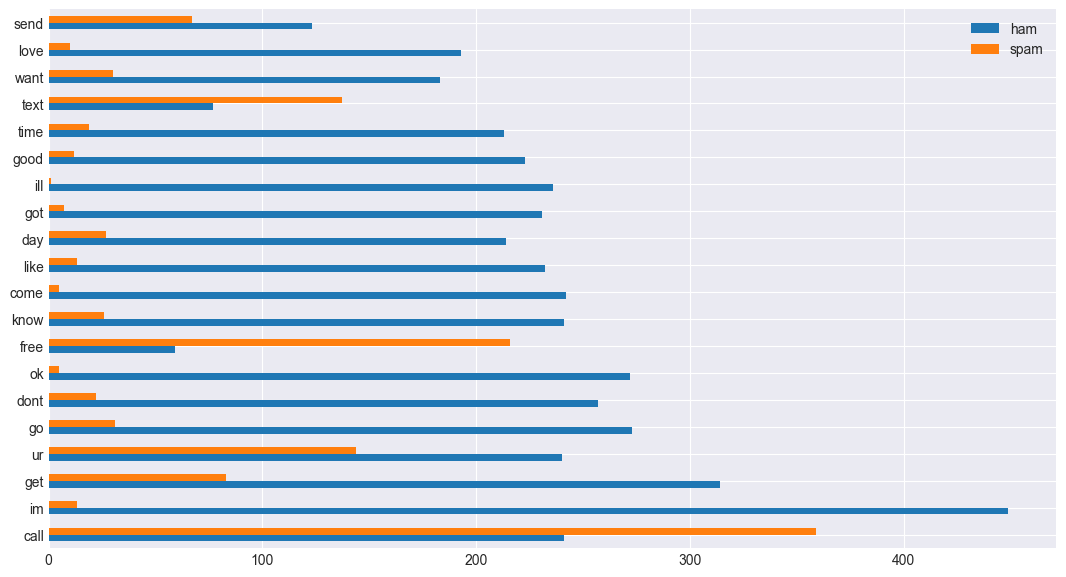

In [16]:
# Sort 'word_counts' by the 'all' column in descending order, select 'ham' and 'spam' columns,
# and plot the top 20 words as a horizontal bar chart
word_counts.sort_values('all', ascending=False)[['ham', 'spam']].head(20).plot.barh()

# Show the plot
plt.show()

In [17]:
word_counts.sort_values('all', ascending=False).head(20)\
.apply(lambda row: row/row['all'], axis=1).head()# Sort 'word_counts' by the 'all' column in descending order and select the top 20 words
top_20_words = word_counts.sort_values('all', ascending=False).head(20)

# Apply a function to normalize the frequencies by dividing each word count by the total count in the 'all' category
normalized_frequencies = top_20_words.apply(lambda row: row / row['all'], axis=1).head()
normalized_frequencies

,ham,spam,all
call,0.401667,0.598333,1.0
im,0.971861,0.028139,1.0
get,0.790932,0.209068,1.0
ur,0.625000,0.375000,1.0
go,0.898026,0.101974,1.0


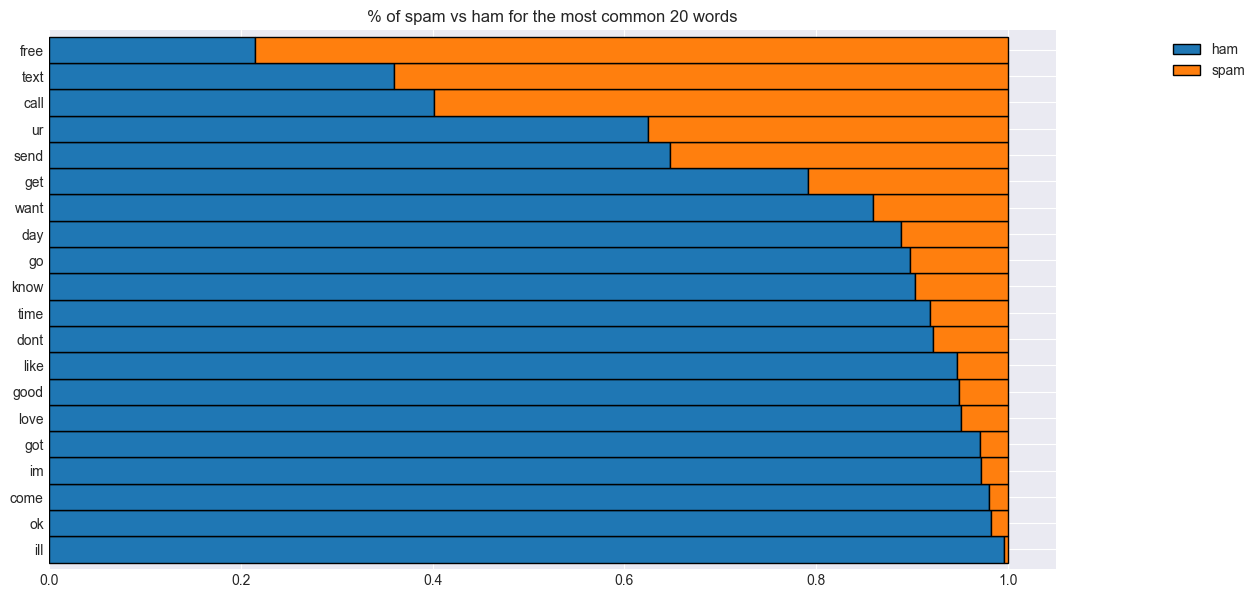

In [18]:
# Sort 'word_counts' by the 'all' column in descending order, select the top 20 words,
# and apply a function to normalize the frequencies by dividing each word count by the total count in the 'all' category.
# Then, drop the 'all' column, sort by the 'spam' column, and create a stacked horizontal bar chart.
(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all'], axis=1)
 .drop(columns='all')
 .sort_values(by='spam')
 .plot.barh(stacked=True, width=1, ec='black')
)

# Set the title for the plot
plt.title('% of spam vs ham for the most common 20 words')

# Add a legend to the plot
plt.legend(bbox_to_anchor=(1.2, 1.0), loc='upper right')

# Show the plot
plt.show()

### n-grams

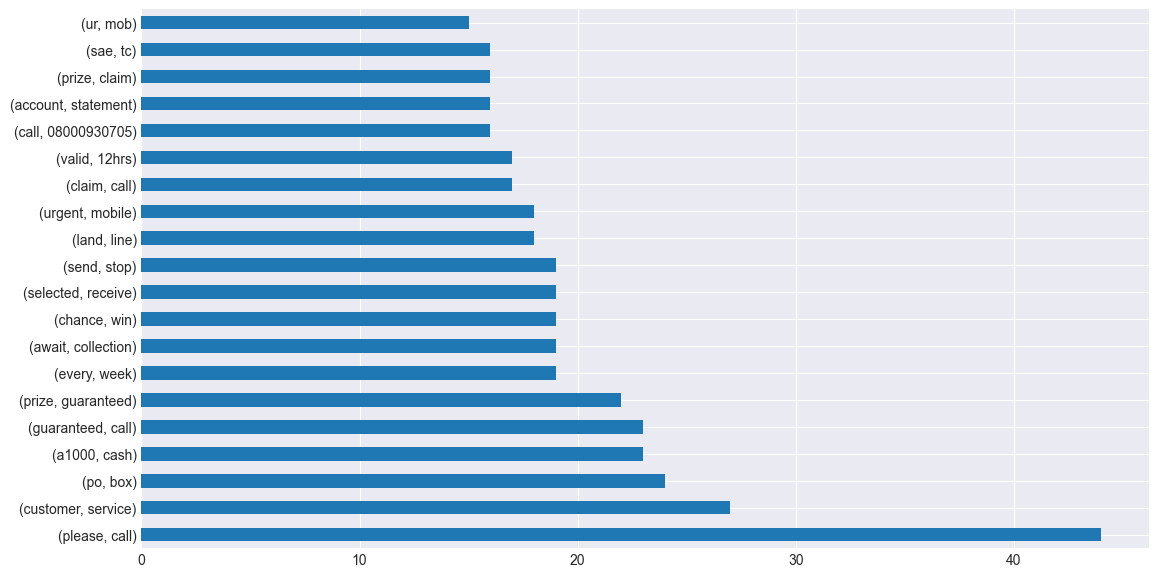

In [19]:
# Generate bigrams from the 'spam_words' list and count their occurrences
bigram_counts = pd.Series(nltk.bigrams(spam_words)).value_counts()

# Plot the top 20 bigrams as a horizontal bar chart
bigram_counts.head(20).plot.barh()

# Show the plot
plt.show()

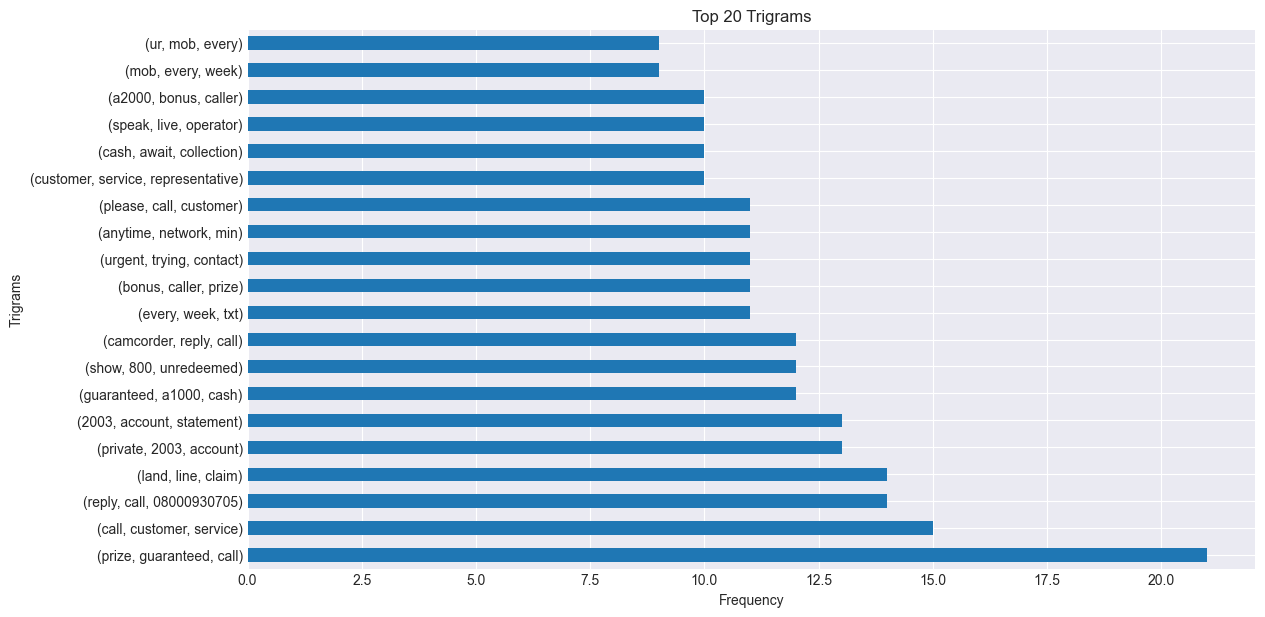

In [20]:
# Generate trigrams from the 'spam_words' list
trigrams = list(ngrams(spam_words, 3))

# Create a Series and count the occurrences of trigrams
trigram_series = pd.Series(trigrams)
trigram_counts = trigram_series.value_counts()

# Select the top 20 trigrams
top_20_trigrams = trigram_counts.head(20)

# Plot the top 20 trigrams as a horizontal bar chart
top_20_trigrams.plot(kind='barh')

# Set labels and title for the plot
plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.title('Top 20 Trigrams')

# Show the plot
plt.show()

### WordCloud 

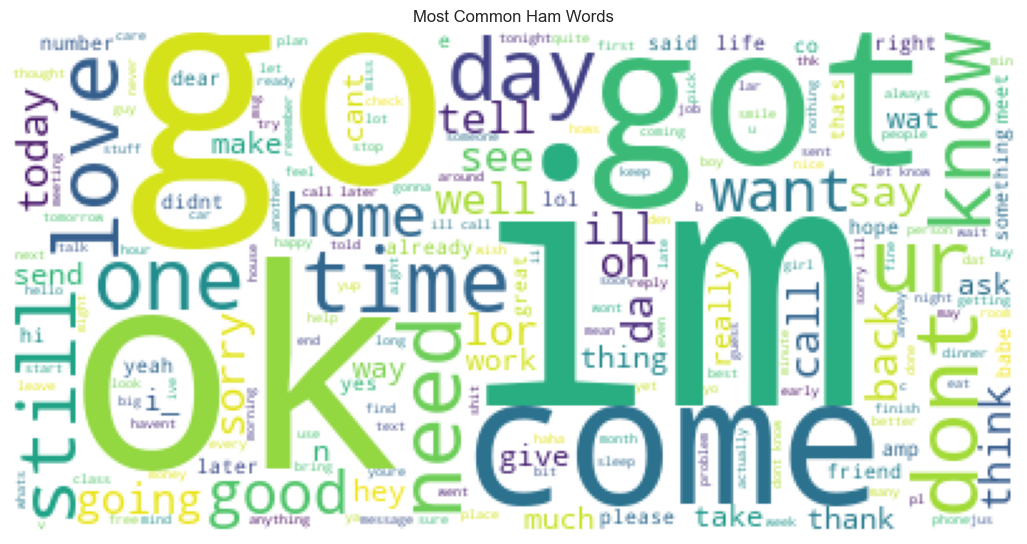

In [21]:
# Generate a word cloud from the 'ham_words' list with a white background
img = WordCloud(background_color='white').generate(' '.join(ham_words))

# Display the word cloud image
plt.imshow(img)

# Turn off the axis (x and y axis)
plt.axis('off')

# Set the title for the plot
plt.title('Most Common Ham Words')

# Show the word cloud plot
plt.show()

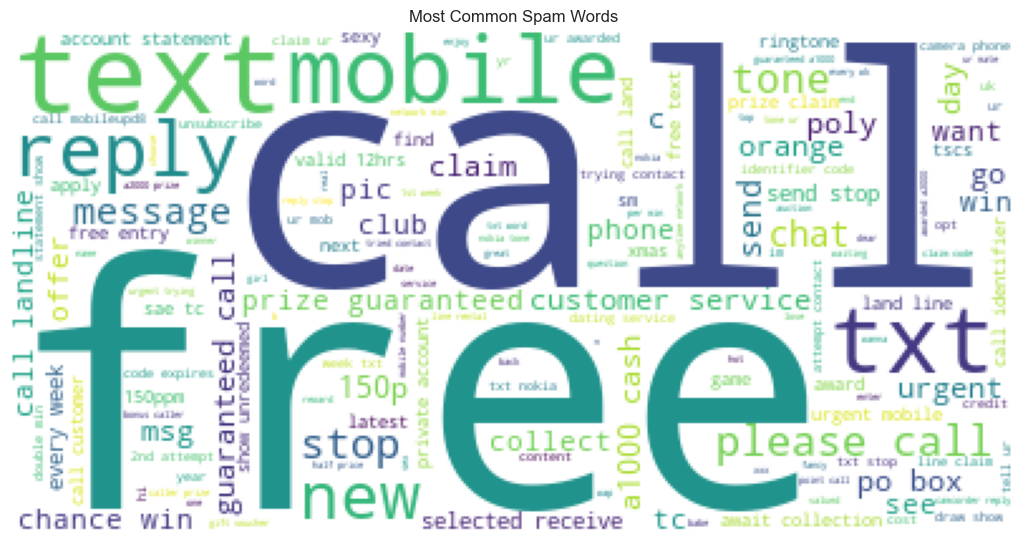

In [22]:
# Generate a word cloud from the 'spam_words' list with a white background
img = WordCloud(background_color='white').generate(' '.join(spam_words))

# Display the word cloud image
plt.imshow(img)

# Turn off the axis (x and y axis)
plt.axis('off')

# Set the title for the plot
plt.title('Most Common Spam Words')

# Show the word cloud plot
plt.show()

In [23]:
# Add a new column 'message_length' to the DataFrame 'df'
# This column contains the character length of each text message in the 'text' column
df['message_length'] = df['text'].str.len()

In [24]:
# Add a new column 'word_count' to the DataFrame 'df'
# This column contains the number of words in each text message after applying the 'clean' function
df['word_count'] = df.text.apply(clean).apply(len)
df.head()

,label,text,message_length,word_count
id,,,,
0,ham,"Go until jurong point, crazy.. Available only ...",111,16
1,ham,Ok lar... Joking wif u oni...,29,5
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,22
3,ham,U dun say so early hor... U c already then say...,49,7
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,8


### Sentiment

In [25]:
# Initialize a Sentiment Intensity Analyzer (SIA) object
sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [26]:
# Add a new column 'sentiment' to the DataFrame 'df'
# This column contains the sentiment polarity scores for each text message
df['sentiment'] = df['text'].apply(lambda doc: sia.polarity_scores(doc)['compound'])
df.head()

,label,text,message_length,word_count,sentiment
id,,,,,
0,ham,"Go until jurong point, crazy.. Available only ...",111,16,0.6249
1,ham,Ok lar... Joking wif u oni...,29,5,0.4767
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,22,0.7964
3,ham,U dun say so early hor... U c already then say...,49,7,0.0000
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,8,-0.1027


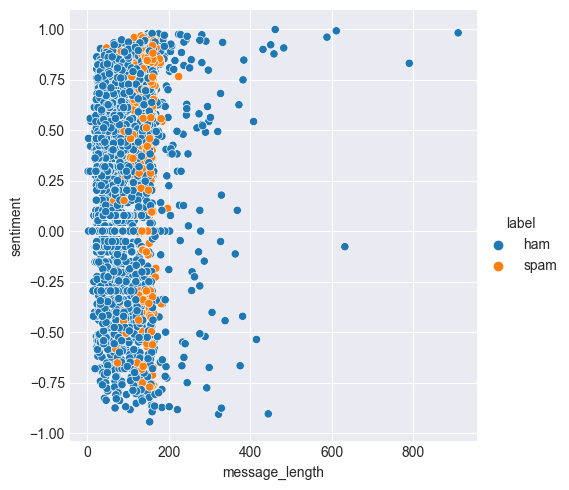

In [27]:
# Create a relational plot using Seaborn
sns.relplot(data=df, x='message_length', y='sentiment', hue='label')

# Show the plot
plt.show()

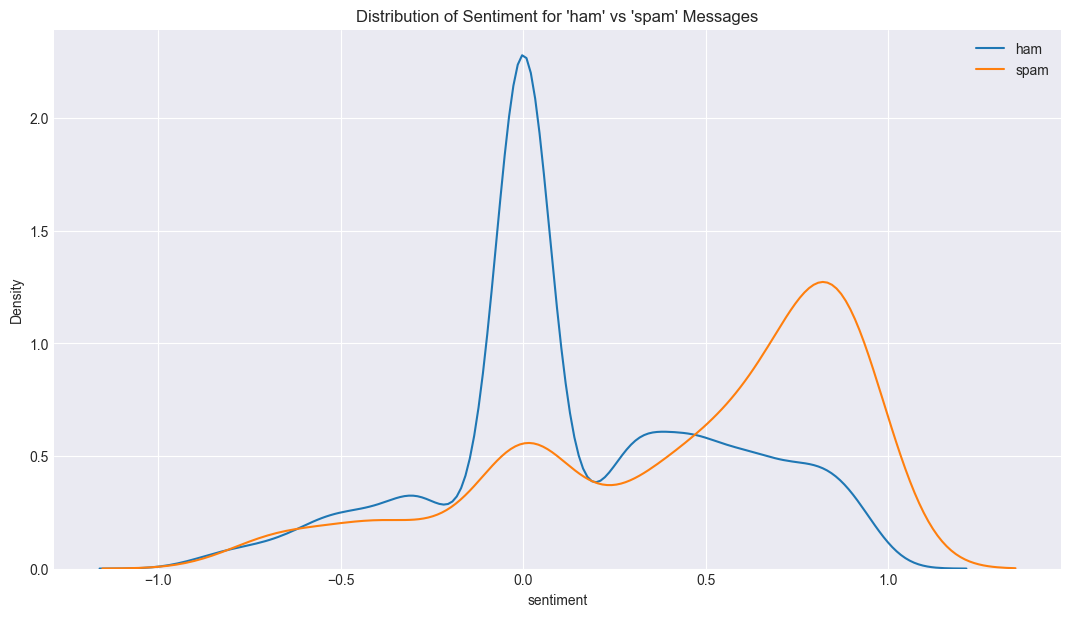

In [28]:
# Create KDE plots for sentiment scores of 'ham' and 'spam' messages
sns.kdeplot(df[df.label == 'ham'].sentiment, label='ham')
sns.kdeplot(df[df.label == 'spam'].sentiment, label='spam')

# Add a legend to the plot
plt.legend(['ham', 'spam'])

# Set a title for the plot
plt.title("Distribution of Sentiment for 'ham' vs 'spam' Messages")

# Show the plot
plt.show()

#### 2) Explore the blog articles using the techniques discussed in the exploration lesson.

### Codeup Blog Articles

In [29]:
df = get_blog_articles_data()
df

,title,content
0,Spotlight on APIDA Voices: Celebrating Heritag...,May is traditionally known as Asian American a...
1,Women in tech: Panelist Spotlight – Magdalena ...,Women in tech: Panelist Spotlight – Magdalena ...
2,Women in tech: Panelist Spotlight – Rachel Rob...,Women in tech: Panelist Spotlight – Rachel Rob...
3,Women in Tech: Panelist Spotlight – Sarah Mellor,Women in tech: Panelist Spotlight – Sarah Mell...
4,Women in Tech: Panelist Spotlight – Madeleine ...,Women in tech: Panelist Spotlight – Madeleine ...
5,Black Excellence in Tech: Panelist Spotlight –...,Black excellence in tech: Panelist Spotlight –...


In [30]:
# Count the occurrences of each unique value in the 'title' column of the DataFrame
label_counts = df['title'].value_counts()

In [31]:
ADDITIONAL_STOPWORDS = ['us']

def clean(text):
    '''
    A simple function to cleanup text data.
    
    Args:
        text (str): The text to be cleaned.
        
    Returns:
        list: A list of lemmatized words after cleaning.
    '''
    
    # Normalize text by removing diacritics, encoding to ASCII, decoding to UTF-8, and converting to lowercase
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    
    # Remove punctuation and split text into words
    words = re.sub(r'[^\w\s]', '', text).split()
    
    # Initialize WordNet lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Combine standard English stopwords with additional stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords = stopwords+ADDITIONAL_STOPWORDS
    
    # Lemmatize words and remove stopwords
    cleaned_words = [wnl.lemmatize(word) for word in words if word not in stopwords]
    
    return cleaned_words

In [32]:
# Preprocess content data for articles with 'APIDA' in their title
# Combine the content of these articles, clean the content, and store it in the 'apida' variable
APIDA = clean(' '.join(df[df.title.str.contains('Spotlight on APIDA Voices')]['content']))

In [33]:
# Preprocess text data for messages with titles containing 'Women in Tech' or 'Women in tech'
# Combine the text of these messages, clean the text, and store it in the 'WIT' variable
WIT = clean(' '.join(df[df.title.str.contains('Women in Tech', case=False)]['content']))

In [34]:
# Preprocess content data for articles with 'Black excellence in tech' in their title
# Combine the content of these articles, clean the content, and store it in the 'BEIT' variable
BEIT = clean(' '.join(df[df.title.str.contains('Black Excellence in Tech')]['content']))

In [35]:
# Preprocess all text data
all_words = clean(' '.join(df['content']))

In [36]:
#Calculate the number of words in the 'APIDA', 'WIT', 'BEIT', 'all_words' sets
APIDA_count = len(APIDA)
WIT_count = len(WIT)
BEIT_count = len(BEIT)
all_words_count = len(all_words)

In [37]:
APIDA_count, WIT_count, BEIT_count, all_words_count

(445, 621, 88, 1154)

### Exploration

In [38]:
# Calculate word frequencies for the 'APIDA' SET
APIDA_freq = pd.Series(APIDA).value_counts()
APIDA_freq.sort_values(ascending=False)

asian           12
apida            9
arbeena          6
community        6
american         6
                ..
natural          1
organization     1
ground           1
career           1
growth           1
Name: count, Length: 291, dtype: int64

In [39]:
# Calculate word frequencies for the 'WIT' set
WIT_freq = pd.Series(WIT).value_counts()

In [40]:
# Calculate word frequencies for the 'BEIT' set
BEIT_freq = pd.Series(BEIT).value_counts()

In [41]:
# Calculate word frequencies for the 'all_words' set
all_words_freq = pd.Series(all_words).value_counts()

In [42]:
#Combine word coumt for 'APIDA', 'WIT', 'BEIT' and 'all_words'
word_counts = pd.concat([APIDA_freq, WIT_freq, BEIT_freq, all_words_freq], axis=1).fillna(0).astype(int)

In [43]:
#set column names to 'APIDA', 'WIT', 'BEIT', 'all'
word_counts.columns = ['APIDA', 'WIT', 'BEIT', 'all']
word_counts.head()

,APIDA,WIT,BEIT,all
asian,12,0,0,12
apida,9,0,0,9
arbeena,6,0,0,6
community,6,1,0,7
american,6,0,0,6


In [44]:
#Sort the 'word_counts' DataFrame by the 'all' column in the descending order
word_counts.sort_values('all', ascending=False).head()

,APIDA,WIT,BEIT,all
codeup,1,19,4,24
woman,2,16,0,18
data,0,17,0,17
tech,0,12,3,15
science,0,14,0,14


In [45]:
#sort the 'word_counts' DataFrame by the columns 'APIDA', 'WIT', 'BEIT' and 'all' in descending order
word_counts_sorted = word_counts.sort_values(['APIDA', 'WIT', 'BEIT', 'all'], ascending=False)
word_counts_sorted.head()

,APIDA,WIT,BEIT,all
asian,12,0,0,12
apida,9,0,0,9
community,6,1,0,7
arbeena,6,0,0,6
american,6,0,0,6


### Visualization

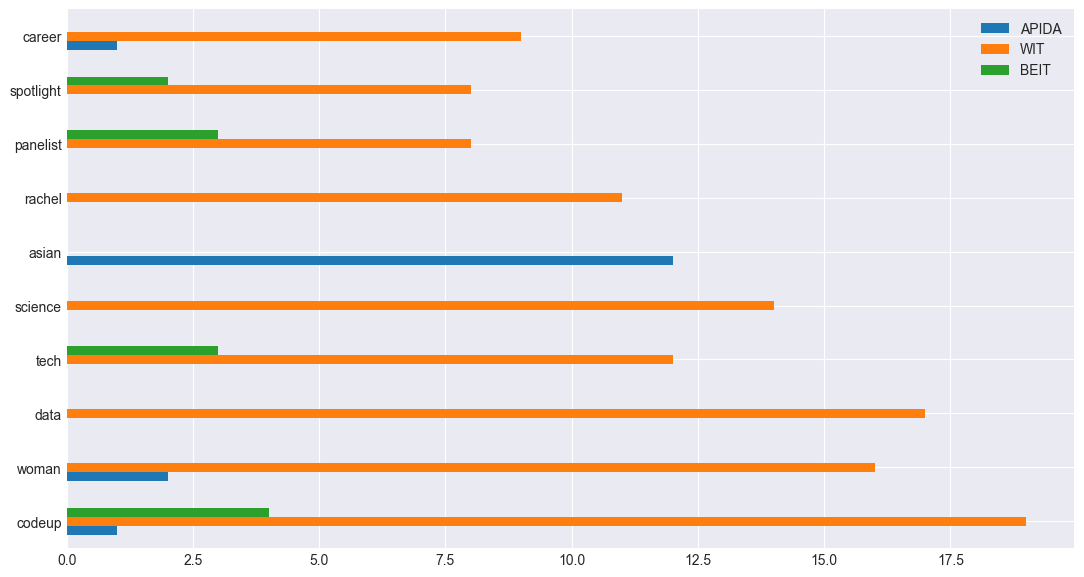

In [46]:
#Set the figure size
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

#Sort 'word_counts' by 'all' column in the descending order, select 'APIDA', 'WIT' and 'BEIT' columns
# and plot the top 20 words as a horizontal bar chart
word_counts.sort_values('all', ascending=False)[['APIDA', 'WIT', 'BEIT']].head(10).plot.barh()
plt.show()

In [47]:
word_counts.sort_values('all', ascending=False).head(20)\
.apply(lambda row: row/row['all'], axis=1).head()# Sort 'word_counts' by the 'all' column in descending order and select the top 20 words
top_20_words = word_counts.sort_values('all', ascending=False).head(20)
top_20_words

,APIDA,WIT,BEIT,all
codeup,1,19,4,24
woman,2,16,0,18
data,0,17,0,17
tech,0,12,3,15
science,0,14,0,14
asian,12,0,0,12
rachel,0,11,0,11
panelist,0,8,3,11
spotlight,0,8,2,10
career,1,9,0,10


In [48]:
# Apply a function to normalize the frequencies by dividing each word count by the total count in the 'all' category
normalized_frequencies = top_20_words.apply(lambda row: row / row['all'], axis=1).head()
normalized_frequencies

,APIDA,WIT,BEIT,all
codeup,0.041667,0.791667,0.166667,1.0
woman,0.111111,0.888889,0.000000,1.0
data,0.000000,1.000000,0.000000,1.0
tech,0.000000,0.800000,0.200000,1.0
science,0.000000,1.000000,0.000000,1.0


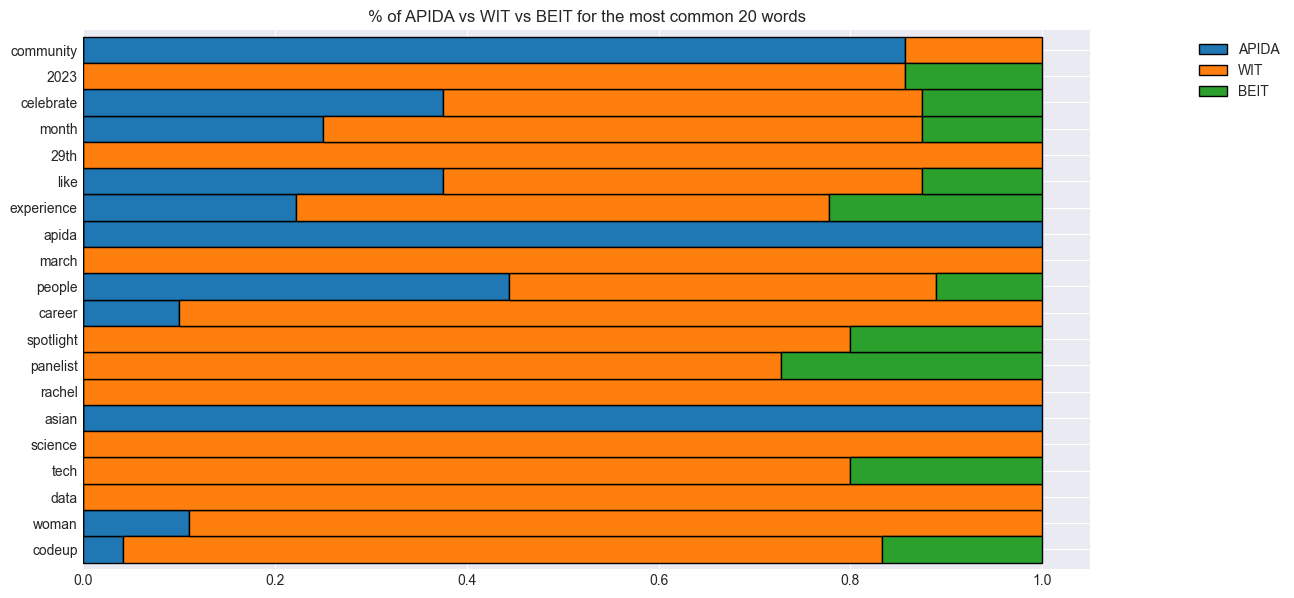

In [49]:
# Sort 'word_counts' by the 'all' column in descending order, select the top 20 words,
# and apply a function to normalize the frequencies by dividing each word count by the total count in the 'all' category.
# Then, drop the 'all' column and create a stacked horizontal bar chart for 'APIDA', 'WIT', and 'BEIT' columns.
(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all'], axis=1)
 .drop(columns='all')
 [['APIDA', 'WIT', 'BEIT']]
 .plot.barh(stacked=True, width=1, ec='black')
)

# Set the title for the plot
plt.title('% of APIDA vs WIT vs BEIT for the most common 20 words')

# Add a legend to the plot
plt.legend(bbox_to_anchor=(1.2, 1.0), loc='upper right')

# Show the plot
plt.show()

## bigrams

#### APIDA(Asian Pacific Islander Desi American)

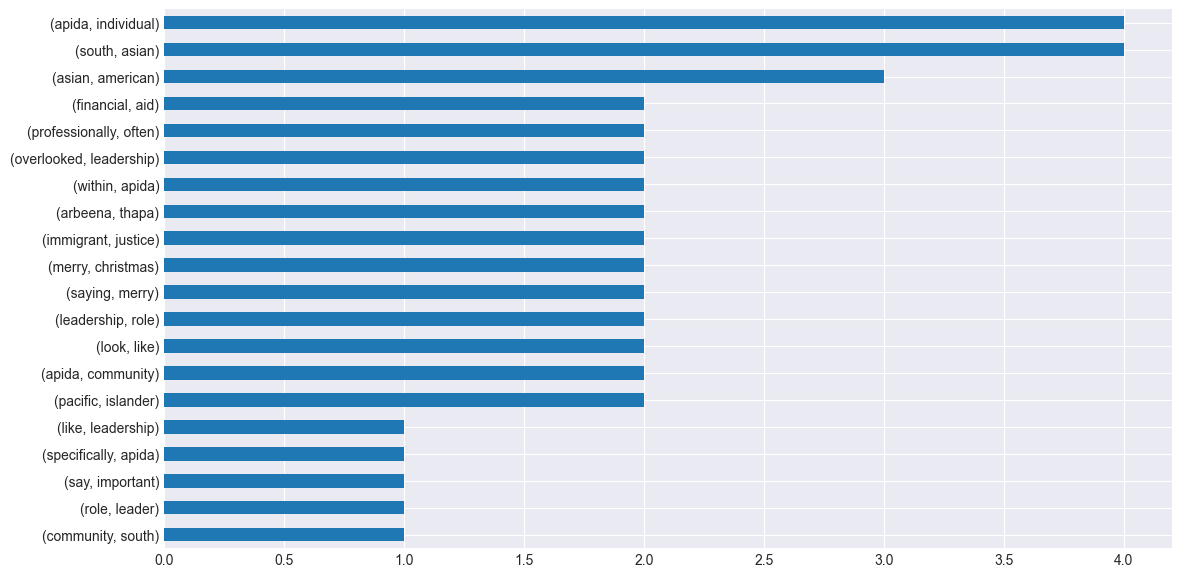

In [50]:
# Generate bigrams from the 'APIDA' list and count their occurrences
bigram_counts = pd.Series(nltk.bigrams(APIDA)).value_counts()

# Plot the top 20 bigrams as a horizontal bar chart with the longest bars at the top
bigram_counts.head(20).sort_values(ascending=True).plot.barh()

# Show the plot
plt.show()

#### WIT(Women In Tech)

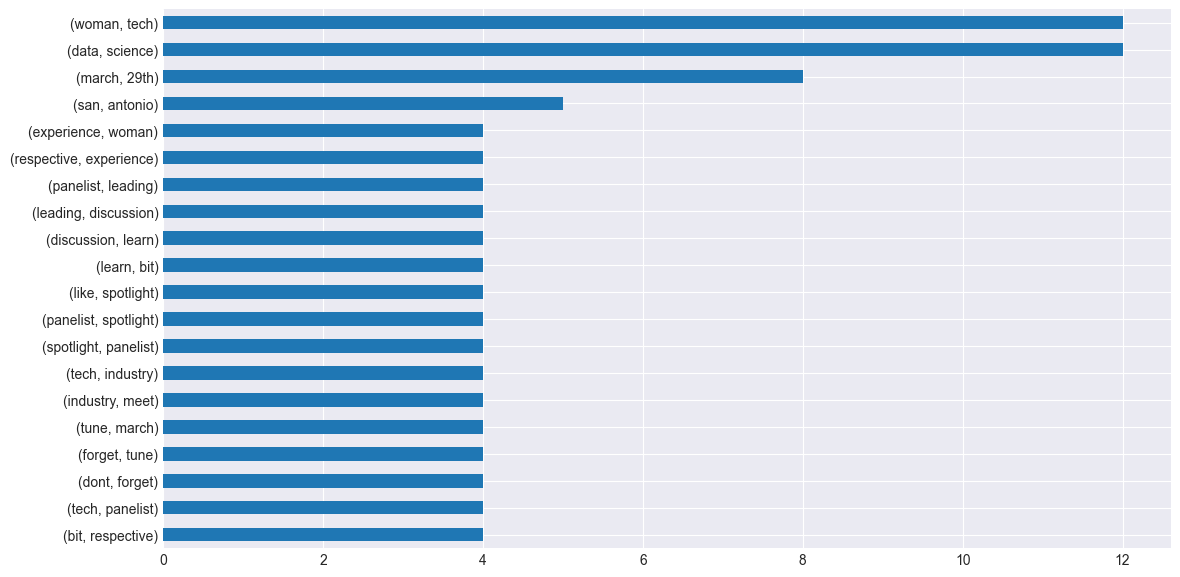

In [51]:
# Generate bigrams from the 'APIDA' list and count their occurrences
bigram_counts = pd.Series(nltk.bigrams(WIT)).value_counts()

# Plot the top 20 bigrams as a horizontal bar chart with the longest bars at the top
bigram_counts.head(20).sort_values(ascending=True).plot.barh()

# Show the plot
plt.show()

#### BEIT(Black excellence In Tech)

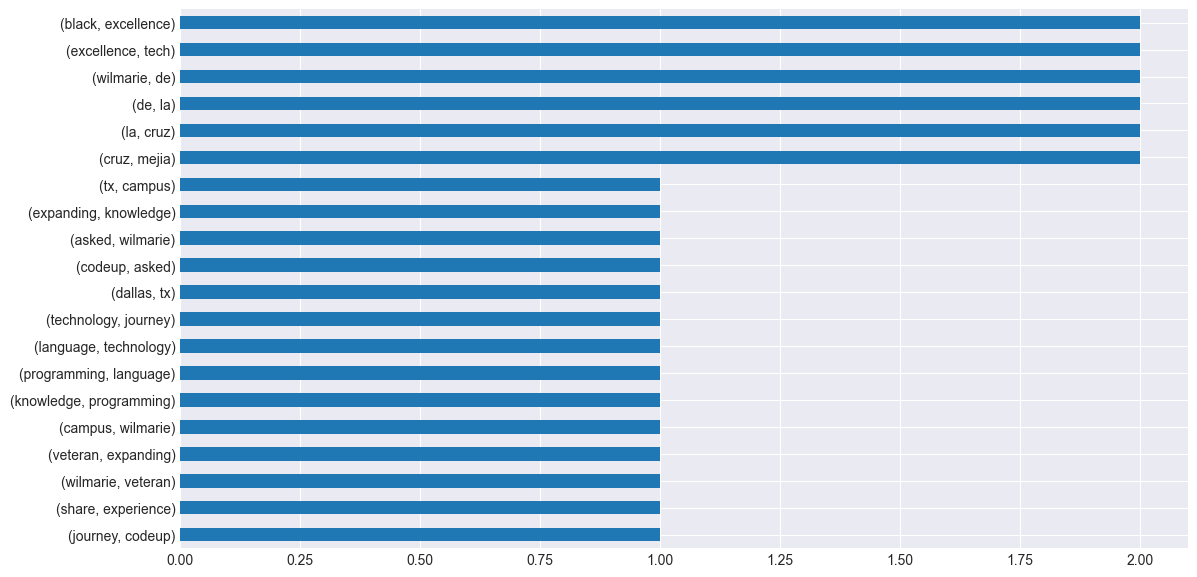

In [52]:
# Generate bigrams from the 'APIDA' list and count their occurrences
bigram_counts = pd.Series(nltk.bigrams(BEIT)).value_counts()

# Plot the top 20 bigrams as a horizontal bar chart with the longest bars at the top
bigram_counts.head(20).sort_values(ascending=True).plot.barh()

# Show the plot
plt.show()

## n-grams

#### APIDA(Asian Pacific Islander Desi American)

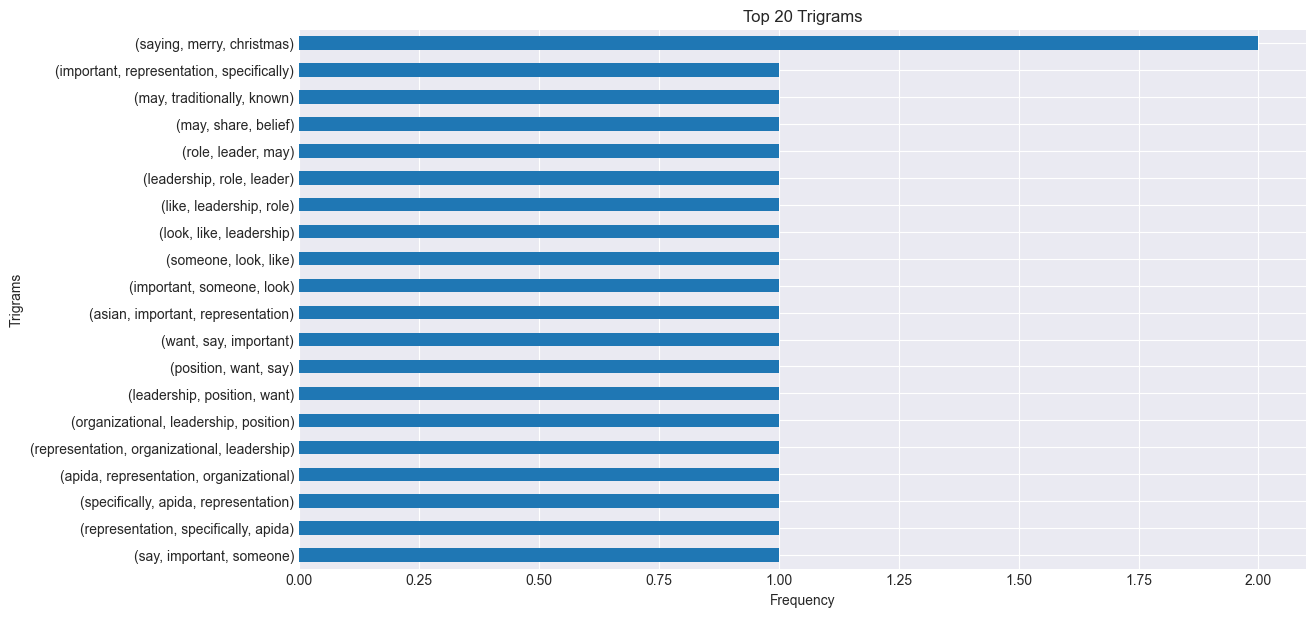

In [53]:
# Generate trigrams from the 'spam_words' list
trigrams = list(ngrams(APIDA, 3))

# Create a Series and count the occurrences of trigrams
trigram_series = pd.Series(trigrams)
trigram_counts = trigram_series.value_counts()

# Select the top 20 trigrams
top_20_trigrams = trigram_counts.head(20)

# Plot the top 20 trigrams as a horizontal bar chart
top_20_trigrams.sort_values(ascending=True).plot(kind='barh')

# Set labels and title for the plot
plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.title('Top 20 Trigrams')

# Show the plot
plt.show()

#### WIT(Women In Tech)

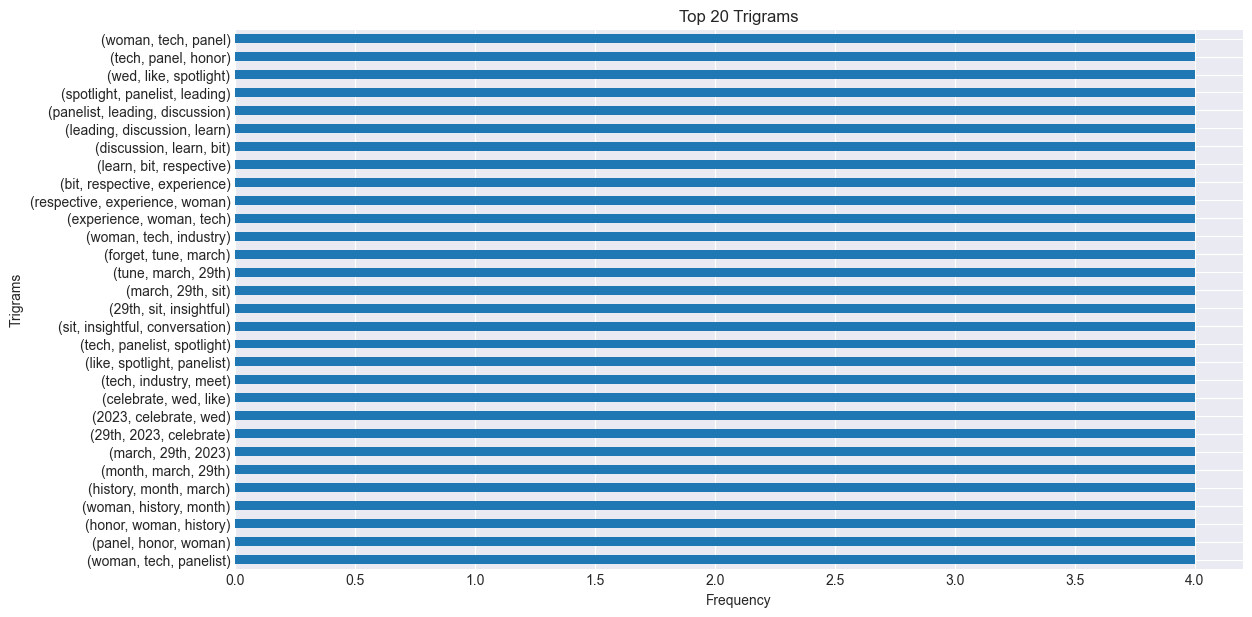

In [54]:
# Generate trigrams from the 'spam_words' list
trigrams = list(ngrams(WIT, 3))

# Create a Series and count the occurrences of trigrams
trigram_series = pd.Series(trigrams)
trigram_counts = trigram_series.value_counts()

# Select the top 20 trigrams
top_20_trigrams = trigram_counts.head(30)

# Plot the top 20 trigrams as a horizontal bar chart
top_20_trigrams.sort_values(ascending=True).plot(kind='barh')

# Set labels and title for the plot
plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.title('Top 20 Trigrams')

# Show the plot
plt.show()

#### BEIT(Black Excellence In Tech)

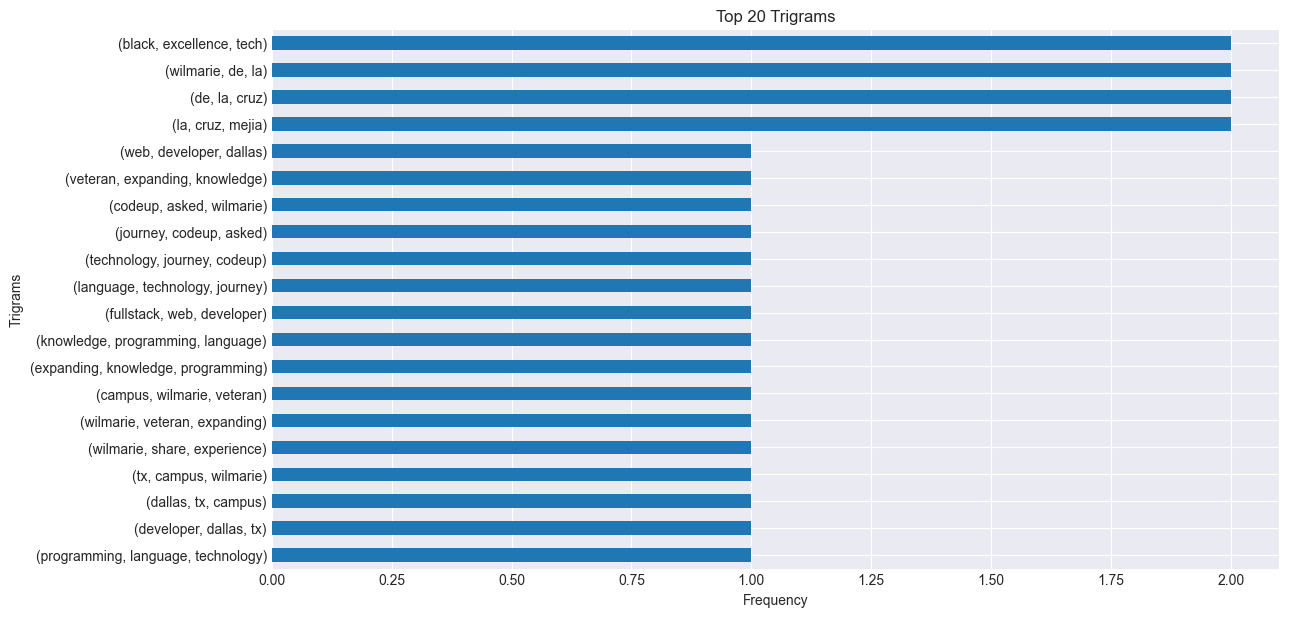

In [55]:
# Generate trigrams from the 'spam_words' list
trigrams = list(ngrams(BEIT, 3))

# Create a Series and count the occurrences of trigrams
trigram_series = pd.Series(trigrams)
trigram_counts = trigram_series.value_counts()

# Select the top 20 trigrams
top_20_trigrams = trigram_counts.head(20)

# Plot the top 20 trigrams as a horizontal bar chart
top_20_trigrams.sort_values(ascending=True).plot(kind='barh')

# Set labels and title for the plot
plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.title('Top 20 Trigrams')

# Show the plot
plt.show()

### WordCloud

#### APIDA(Asian Pacific Islander Desi American)

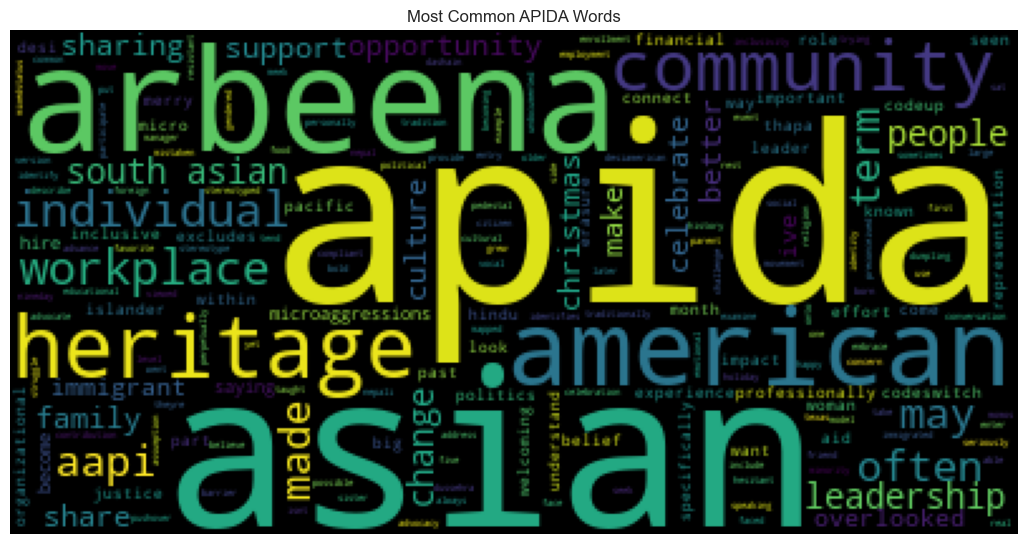

In [56]:
#Generate a word cloud from the 'APIDA' list with a white background
img = WordCloud(background_color='black').generate(' '.join(APIDA))

# Display the word cloud image
plt.imshow(img)

# Turn off the axis (x and y axis)
plt.axis('off')

# Set the title for the plot
plt.title('Most Common APIDA Words')

# Show the word cloud plot
plt.show()

#### WIT(Women In Tech)

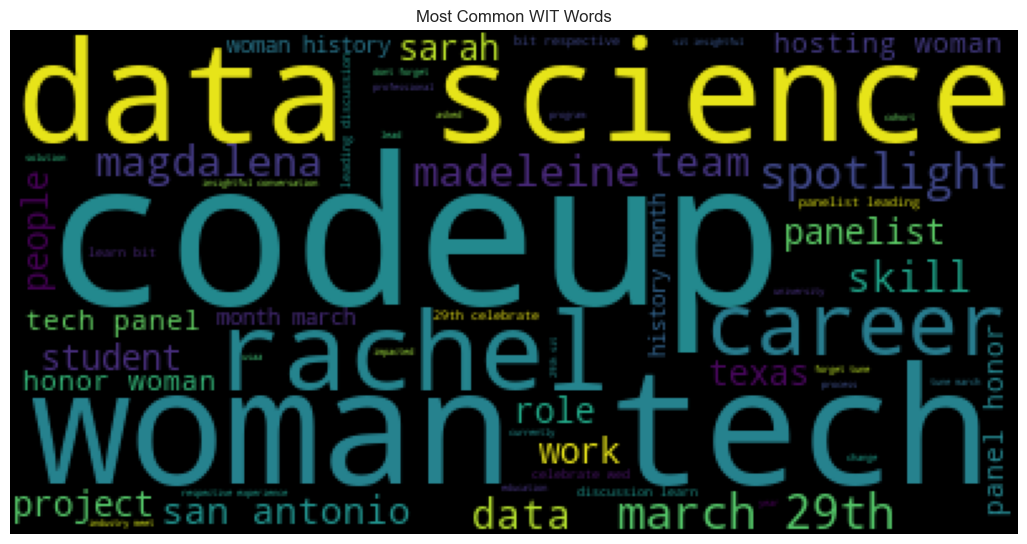

In [57]:
# Generate a word cloud from the 'ham_words' list with a white background
img = WordCloud(background_color='black').generate(' '.join(WIT))

# Display the word cloud image
plt.imshow(img)

# Turn off the axis (x and y axis)
plt.axis('off')

# Set the title for the plot
plt.title('Most Common WIT Words')

# Show the word cloud plot
plt.show()

#### BEIT(Black Excellence In Tech)

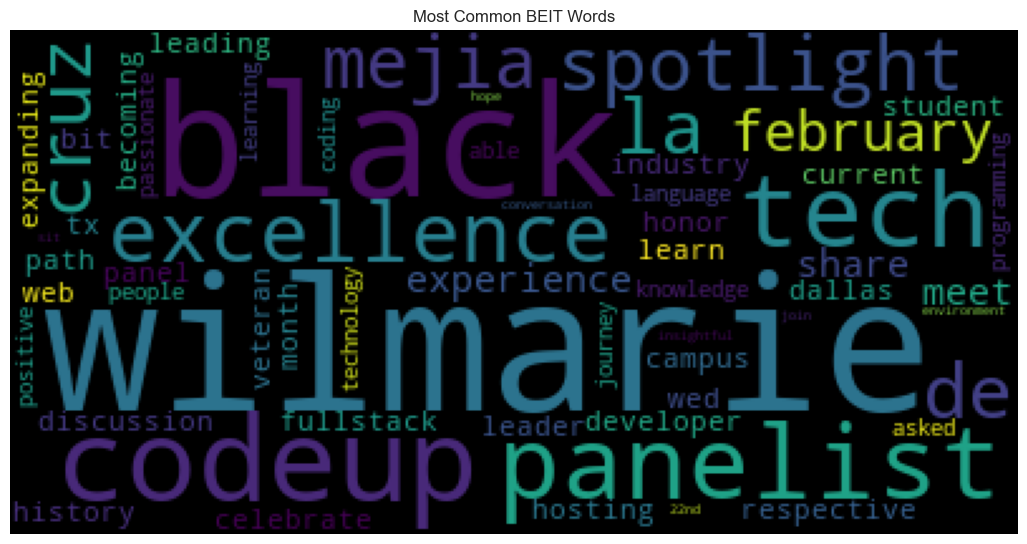

In [58]:
# Generate a word cloud from the 'ham_words' list with a white background
img = WordCloud(background_color='black').generate(' '.join(BEIT))

# Display the word cloud image
plt.imshow(img)

# Turn off the axis (x and y axis)
plt.axis('off')

# Set the title for the plot
plt.title('Most Common BEIT Words')

# Show the word cloud plot
plt.show()

In [59]:
# Add a new column 'message_length' to the DataFrame 'df'
# This column contains the character length of each text message in the 'text' column
df['article_length'] = df['content'].str.len()


In [60]:
# Add a new column 'word_count' to the DataFrame 'df'
# This column contains the number of words in each text message after applying the 'clean' function
df['word_count'] = df.content.apply(clean).apply(len)
df

,title,content,article_length,word_count
0,Spotlight on APIDA Voices: Celebrating Heritag...,May is traditionally known as Asian American a...,5252,445
1,Women in tech: Panelist Spotlight – Magdalena ...,Women in tech: Panelist Spotlight – Magdalena ...,1177,108
2,Women in tech: Panelist Spotlight – Rachel Rob...,Women in tech: Panelist Spotlight – Rachel Rob...,2722,257
3,Women in Tech: Panelist Spotlight – Sarah Mellor,Women in tech: Panelist Spotlight – Sarah Mell...,1343,130
4,Women in Tech: Panelist Spotlight – Madeleine ...,Women in tech: Panelist Spotlight – Madeleine ...,1322,126
5,Black Excellence in Tech: Panelist Spotlight –...,Black excellence in tech: Panelist Spotlight –...,936,88


## Sentiment

In [61]:
# Initialize a Sentiment Intensity Analyzer(SIA) object
sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [62]:
#Add a new column 'sentiment' to the DataFrame
#This column contains the sentiment polarity scores for each article
df['sentiment'] = df['content'].apply(lambda doc: sia.polarity_scores(doc)['compound'])
df

,title,content,article_length,word_count,sentiment
0,Spotlight on APIDA Voices: Celebrating Heritag...,May is traditionally known as Asian American a...,5252,445,0.9990
1,Women in tech: Panelist Spotlight – Magdalena ...,Women in tech: Panelist Spotlight – Magdalena ...,1177,108,0.9660
2,Women in tech: Panelist Spotlight – Rachel Rob...,Women in tech: Panelist Spotlight – Rachel Rob...,2722,257,0.9948
3,Women in Tech: Panelist Spotlight – Sarah Mellor,Women in tech: Panelist Spotlight – Sarah Mell...,1343,130,0.9806
4,Women in Tech: Panelist Spotlight – Madeleine ...,Women in tech: Panelist Spotlight – Madeleine ...,1322,126,0.9728
5,Black Excellence in Tech: Panelist Spotlight –...,Black excellence in tech: Panelist Spotlight –...,936,88,0.9908


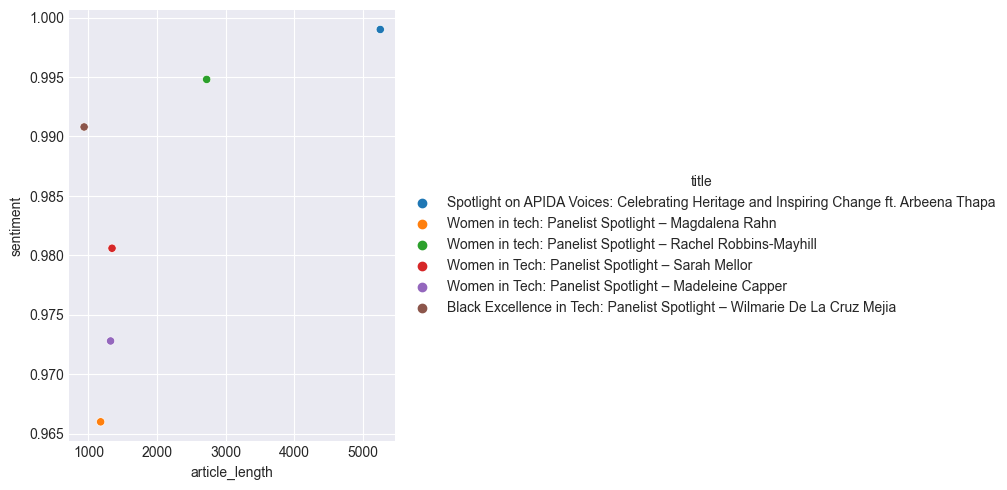

In [63]:
#Create a relational plot 
sns.relplot(data=df, x='article_length', y='sentiment', hue='title')
plt.show()

## News Articles

In [2]:
# Define the URL to the webpage you want to scrape
url = 'https://inshorts.com/'
# Define the User-Agent header to be used in the HTTP request
headers = {'User-Agent': 'Codeup Data Science'}

In [3]:
links = get_new_links(url, headers, 'div', 'a', 'href')

In [ ]:
df = get_news_article(links, headers)

In [ ]:
# Count the occurrences of each unique value in the 'label' column of the DataFrame
label_counts = df['title'].str.value_counts()

In [ ]:
def clean(text):
    '''
    A simple function to cleanup text data.
    
    Args:
        text (str): The text to be cleaned.
        
    Returns:
        list: A list of lemmatized words after cleaning.
    '''
    
    # Normalize text by removing diacritics, encoding to ASCII, decoding to UTF-8, and converting to lowercase
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    
    # Remove punctuation and split text into words
    words = re.sub(r'[^\w\s]', '', text).split()
    
    # Initialize WordNet lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Combine standard English stopwords with additional stopwords
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    
    # Lemmatize words and remove stopwords
    cleaned_words = [wnl.lemmatize(word) for word in words if word not in stopwords]
    
    return cleaned_words


In [ ]:
# Preprocess text data for 'ham' label
isshorts_words = clean(' '.join(df[df.label == "ham"]['text']))

In [ ]:

# Preprocess text data for 'ham' label
ham_words = clean(' '.join(df[df.label == "ham"]['text']))

# Preprocess text data for 'spam' label
spam_words = clean(' '.join(df[df.label == "spam"]['text']))

# Preprocess all text data
all_words = clean(' '.join(df['text']))

# Calculate the number of words in the 'all_words' set
all_words_count = len(all_words)

# Calculate the number of words in the 'spam_words' set
spam_words_count = len(spam_words)

# Calculate the number of words in the 'ham_words' set
ham_words_count = len(ham_words)

all_words_count, spam_words_count, ham_words_count

In [ ]:
### Exploration

# Calculate word frequencies for the 'ham_words' set
ham_freq = pd.Series(ham_words).value_counts()

# Calculate word frequencies for the 'spam_words' set
spam_freq = pd.Series(spam_words).value_counts()

# Calculate word frequencies for the 'all_words' set
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()
ham_freq.head()

# Combine word counts for 'ham', 'spam', and 'all' sets into a DataFrame
word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)

# Set column names to 'ham', 'spam', and 'all'
word_counts.columns = ['ham', 'spam', 'all']

# Display the first few rows of the DataFrame
word_counts.head()

# Sort the 'word_counts' DataFrame by the 'all' column in descending order
# and display the top few rows
word_counts_sorted = word_counts.sort_values('all', ascending=False).head()
word_counts_sorted

# Sort the 'word_counts' DataFrame by the columns 'ham,' 'spam,' and 'all' in descending order
# and display the top few rows
word_counts_sorted = word_counts.sort_values(['ham', 'spam', 'all'], ascending=False).head()
word_counts_sorted



In [ ]:
### Visualization

# Set the figure size for Matplotlib plots
plt.rc('figure', figsize=(13, 7))

# Set the style for Matplotlib plots to 'seaborn-darkgrid'
plt.style.use('seaborn-darkgrid')

# Sort 'word_counts' by the 'all' column in descending order, select 'ham' and 'spam' columns,
# and plot the top 20 words as a horizontal bar chart
word_counts.sort_values('all', ascending=False)[['ham', 'spam']].head(20).plot.barh()

# Show the plot
plt.show()

word_counts.sort_values('all', ascending=False).head(20)\
.apply(lambda row: row/row['all'], axis=1).head()# Sort 'word_counts' by the 'all' column in descending order and select the top 20 words
top_20_words = word_counts.sort_values('all', ascending=False).head(20)

# Apply a function to normalize the frequencies by dividing each word count by the total count in the 'all' category
normalized_frequencies = top_20_words.apply(lambda row: row / row['all'], axis=1).head()
normalized_frequencies

# Sort 'word_counts' by the 'all' column in descending order, select the top 20 words,
# and apply a function to normalize the frequencies by dividing each word count by the total count in the 'all' category.
# Then, drop the 'all' column, sort by the 'spam' column, and create a stacked horizontal bar chart.
(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all'], axis=1)
 .drop(columns='all')
 .sort_values(by='spam')
 .plot.barh(stacked=True, width=1, ec='black')
)

# Set the title for the plot
plt.title('% of spam vs ham for the most common 20 words')

# Add a legend to the plot
plt.legend(bbox_to_anchor=(1.2, 1.0), loc='upper right')

# Show the plot
plt.show()



In [ ]:
### n-grams

# Generate bigrams from the 'spam_words' list and count their occurrences
bigram_counts = pd.Series(nltk.bigrams(spam_words)).value_counts()

# Plot the top 20 bigrams as a horizontal bar chart
bigram_counts.head(20).plot.barh()

# Show the plot
plt.show()

# Generate trigrams from the 'spam_words' list
trigrams = list(ngrams(spam_words, 3))

# Create a Series and count the occurrences of trigrams
trigram_series = pd.Series(trigrams)
trigram_counts = trigram_series.value_counts()

# Select the top 20 trigrams
top_20_trigrams = trigram_counts.head(20)

# Plot the top 20 trigrams as a horizontal bar chart
top_20_trigrams.plot(kind='barh')

# Set labels and title for the plot
plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.title('Top 20 Trigrams')

# Show the plot
plt.show()

### WordCloud 

# Generate a word cloud from the 'ham_words' list with a white background
img = WordCloud(background_color='white').generate(' '.join(ham_words))

# Display the word cloud image
plt.imshow(img)

# Turn off the axis (x and y axis)
plt.axis('off')

# Set the title for the plot
plt.title('Most Common Ham Words')

# Show the word cloud plot
plt.show()


# Generate a word cloud from the 'spam_words' list with a white background
img = WordCloud(background_color='white').generate(' '.join(spam_words))

# Display the word cloud image
plt.imshow(img)

# Turn off the axis (x and y axis)
plt.axis('off')

# Set the title for the plot
plt.title('Most Common Spam Words')

# Show the word cloud plot
plt.show()


# Add a new column 'message_length' to the DataFrame 'df'
# This column contains the character length of each text message in the 'text' column
df['message_length'] = df['text'].str.len()


# Add a new column 'word_count' to the DataFrame 'df'
# This column contains the number of words in each text message after applying the 'clean' function
df['word_count'] = df.text.apply(clean).apply(len)
df.head()